In [20]:
# download annual historical data for the stock
import pandas as pd
df = pd.read_csv("MSFT.csv")
df = df.sort_values(by="Date")
df = df.dropna()
# calculate returns
df = df.assign(close_day_before=df.Close.shift(1))
df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)

# get options data from yahoo finance // in this case, exercise data is july 24th
r = pd.read_html('https://finance.yahoo.com/quote/MSFT/options?date=1609372800&p=MSFT')[0]

In [21]:
len(r)

25

In [22]:
r.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,MSFT201231C00185000,2020-12-24 11:37AM EST,185.0,37.25,37.45,38.20,0.20,+0.54%,2,24,71.09%
1,MSFT201231C00190000,2020-12-24 10:52AM EST,190.0,33.00,32.45,33.20,0.53,+1.63%,8,101,62.11%
2,MSFT201231C00192500,2020-12-23 12:31PM EST,192.5,30.60,30.00,30.70,0.00,-,2,7,59.96%
3,MSFT201231C00195000,2020-12-24 10:08AM EST,195.0,27.55,27.50,28.20,0.04,+0.15%,3,62,55.47%
4,MSFT201231C00197500,2020-12-23 9:50AM EST,197.5,25.20,25.15,25.55,0.00,-,4,19,50.78%


In [23]:
# S is the spot price 
# K is the strike price 
# T is the fraction of days to strike date divided by 252 (stock market days)
# r is the risk free rate
# sigma is the annual volatility of the returns of the stock 

def black_scholes(S, K, T, r, sigma):
    d1 = np.log(S/(K/(1 + r)**T)/(sigma*sqrt(T))) + (sigma*sqrt(T))/2
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - (K/(1 + r)**T) * norm.cdf(d2)

In [24]:
from math import sqrt
import numpy as np
from scipy.stats import norm

# Calculate the volatility as the annualized standard deviation of the stock returns
sigma = np.sqrt(252) * df['returns'].std()

list_estimates = []

# currently 35 different strike prices for call contracts 
for x in range(0,25):
    value_s = black_scholes(S = 222.75, 
                            K = r['Strike'][x], 
                            T = (40/252), 
                            r = 0.0094, 
                            sigma = sigma)
    list_estimates.append(value_s)
    

# merge the two lists to compare results
df_list = pd.DataFrame(data=list_estimates, index=r.index)
df_list['estimate_1'] = df_list[0]
del df_list[0]
df_estimate = r.merge(df_list, right_index = True, left_index = True)

In [25]:
df_estimate.tail()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate_1
20,MSFT201231C00237500,2020-12-24 12:56PM EST,237.5,0.09,0.07,0.11,-0.05,-35.71%,281,1639,30.08%,-9.764220
21,MSFT201231C00240000,2020-12-24 12:49PM EST,240.0,0.08,0.07,0.10,-0.02,-20.00%,466,1669,33.50%,-12.033298
22,MSFT201231C00242500,2020-12-24 12:52PM EST,242.5,0.07,0.06,0.08,-0.02,-22.22%,141,625,36.04%,-14.296247
23,MSFT201231C00245000,2020-12-24 12:50PM EST,245.0,0.05,0.03,0.06,-0.01,-16.67%,83,596,38.09%,-16.553029
24,MSFT201231C00250000,2020-12-24 12:54PM EST,250.0,0.04,0.01,0.05,-0.01,-20.00%,340,1270,43.75%,-21.047935


In [27]:
df_estimate['estimate_error'] = ((df_estimate['Ask']-df_estimate['estimate_1'])/df_estimate['estimate_1'])*100

df_estimate['estimate_error'].describe()

count     25.000000
mean     -51.092794
std       52.522587
min     -201.994200
25%     -100.559587
50%      -24.033815
75%       -8.932106
max       -2.590357
Name: estimate_error, dtype: float64

/home/avocado/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


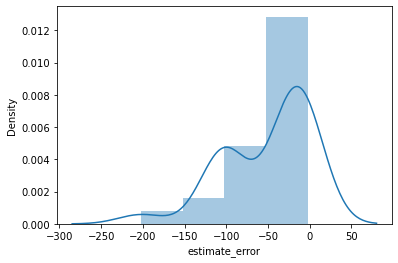

In [28]:
import seaborn as sns, numpy as np
ax = sns.distplot(df_estimate['estimate_error'])

/home/avocado/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


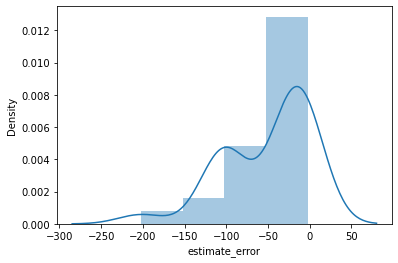

In [29]:
df1 = df_estimate[(df_estimate.Volume != '-')]
ax = sns.distplot(df1['estimate_error'])

In [30]:
df1[df1['estimate_error'] > 1]

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate_1,estimate_error
